In [1]:
import scipy as sp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy as ap
import pandas as pd
import astropy.cosmology as apc
from astropy.cosmology import Planck18
import bagpipes as pp
import astropy.units as u
import kcorrect.utils
from astropy.io import fits
from mpl_toolkits.mplot3d import axes3d

c = 3e18    #A * Hz
cosmo = Planck18

In [ ]:
df = pd.read_csv("~/Desktop/MT/galaxies_for_test_dr8.csv")


# df.iloc[997:999, 1:4 ]
# values of a sub dataframe: 
# df[['objid', 'z_err']].values


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   specobjid        10000 non-null  int64  
 1   objid            10000 non-null  int64  
 2   lgm_tot_p50      10000 non-null  float64
 3   lgm_tot_p16      10000 non-null  float64
 4   lgm_tot_p84      10000 non-null  float64
 5   z                10000 non-null  float64
 6   z_err            10000 non-null  float64
 7   modelmag_u       10000 non-null  float64
 8   modelmag_g       10000 non-null  float64
 9   modelmag_r       10000 non-null  float64
 10  modelmag_i       10000 non-null  float64
 11  modelmag_z       10000 non-null  float64
 12  modelmagErr_u    10000 non-null  float64
 13  modelmagErr_g    10000 non-null  float64
 14  modelmagErr_r    10000 non-null  float64
 15  modelmagErr_i    10000 non-null  float64
 16  modelmagErr_z    10000 non-null  float64
 17  modelFlux_u  

In [136]:
df[[f'modelFluxivar_{ii}' for ii in 'ugriz'] ] [ (df[[f'modelFluxivar_{ii}' for ii in 'ugriz'] ] <=0.0).values]

,modelFluxivar_u,modelFluxivar_g,modelFluxivar_r,modelFluxivar_i,modelFluxivar_z
6169,2.662389,0.000000,3.580054,0.000000,0.0
6169,2.662389,0.000000,3.580054,0.000000,0.0
6169,2.662389,0.000000,3.580054,0.000000,0.0
6829,1.337380,2.709061,1.172498,0.657694,0.0


In [148]:
# data loading for first ten objects
#test = pd.read_csv('/home/yavuz/Desktop/MT/galaxies_for_test_dr8.csv',engine='python',skipfooter=9980)
test = df.iloc[:, : ] # iloc = index location ; syntax are [row, columns]

x = len(test)

bands = ['modelmag_u', 'modelmag_g','modelmag_r','modelmag_i','modelmag_z']
m_k = test[bands]            # appmags with k inside

ab = {'modelmag_u':[-0.04]*x,'modelmag_g':[0]*x,'modelmag_r':[0]*x,'modelmag_i':[0]*x,'modelmag_z':[0.02]*x} # SDSS to AB mapping
abtosdss= pd.DataFrame(data=ab)
m_k = m_k.add(abtosdss)      # AB corrected magnitude values from SDSS

banderrs = ['modelmagErr_u', 'modelmagErr_g','modelmagErr_r','modelmagErr_i','modelmagErr_z']
m_k_errs = test[banderrs]    # appmag errors

phot_reds = test['z']        # photometric redshifts
phot_reds_err = test['z_err']# redshift errors

ivars = ['modelFluxivar_u', 'modelFluxivar_g','modelFluxivar_r','modelFluxivar_i','modelFluxivar_z']
ivar = test[ivars]           # ivars for bands

absmags = ['absMagU','absMagG','absMagR','absMagI','absMagZ']
absmagtest = test[absmags]
absmagtest = absmagtest.to_numpy(dtype=float)

fluxess = ['modelFlux_u','modelFlux_g','modelFlux_r','modelFlux_i','modelFlux_z']
fluxtest = test[fluxess]    # flux_nu in nanomaggies

kcorrbands = ['kcorrU','kcorrG','kcorrR','kcorrI','kcorrZ']
k_corr_cat = test[kcorrbands] # k-correct from catalog
k_corr_cat = k_corr_cat.to_numpy(dtype=float)

sm = test['lgm_tot_p50']    # stellar mass from SDSS
smh = test['lgm_tot_p84']   # upper limit
sml = test['lgm_tot_p16']   # lower limit
sm = sm.to_numpy(dtype=float)
smh = smh.to_numpy(dtype=float)
sml = sml.to_numpy(dtype=float)
smerrup = smh-sm
smerrlo = sm-sml
smtoterr = [smerrlo,smerrup]    # defining total error

d_L = cosmo.luminosity_distance(phot_reds)/u.Mpc # d_L = c/H_0 * z approx.
d_Lerr = cosmo.luminosity_distance(phot_reds_err)/u.Mpc
DM = 25 + 5*np.log10(d_L)
DM = DM.transpose()
DM = np.broadcast_to(DM.reshape(-1,1), (x,5))
DM_err = 5/(np.log(10)*d_L) * d_Lerr
DM_err = DM_err.transpose()
DM_err = np.broadcast_to(DM_err.reshape(-1,1), (x,5))

# for combination
m_k_errs = m_k_errs.rename(columns={"modelmagErr_u":"modelmag_u", "modelmagErr_g":"modelmag_g","modelmagErr_r":"modelmag_r","modelmagErr_i":"modelmag_i","modelmagErr_z":"modelmag_z"})

/home/yavuz/miniforge3/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/yavuz/miniforge3/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/yavuz/miniforge3/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Test for my fluxes vs. catalog fluxes

In [149]:
f_nu_k = 10**(-0.4*(m_k + 48.6))        # 'dirty' appmags -> 'dirty' f_nu in erg/s/Hz/cm^2
err_fnu = m_k_errs * 0.4 * np.log(10) * 10**(-0.4*(m_k + 48.6)) # from f_err**2 = |df/dm|**2 m_err**2 
err_fnu = err_fnu.rename(columns={"modelmag_u":"modelmagErr_u", "modelmag_g":"modelmagErr_g","modelmag_r":"modelmagErr_r","modelmag_i":"modelmagErr_i","modelmag_z":"modelmagErr_z"})

f_nu_kJ = f_nu_k * 10**32/3631 # transform to nanomaggies (3631 from Jy)
f_J = f_nu_kJ.rename(columns={"modelmag_g":"modelFlux_g", "modelmag_r":"modelFlux_r","modelmag_i":"modelFlux_i","modelmag_z":"modelFlux_z","modelmag_u":"modelFlux_u"})
print(fluxtest/f_J) # flux test

err_fnuJ = err_fnu * 10**32/3631
fluxtest_err = np.sqrt(1/ivar)
fluxtest_err = fluxtest_err.rename(columns={"modelFluxivar_g":"modelmagErr_g", "modelFluxivar_r":"modelmagErr_r",
                                            "modelFluxivar_i":"modelmagErr_i","modelFluxivar_z":"modelmagErr_z","modelFluxivar_u":"modelmagErr_u"})
print(fluxtest_err/err_fnuJ) # error test

      modelFlux_u  modelFlux_g  modelFlux_r  modelFlux_i  modelFlux_z
0        0.963177     1.000052     1.000060     1.000059     1.018640
1        0.963830     1.000057     1.000058     1.000057     1.018620
2        0.949111     0.999946     1.000052     1.000054     1.018596
3        0.963658     1.000055     1.000060     1.000059     1.018637
4        0.963678     1.000058     1.000060     1.000060     1.018649
...           ...          ...          ...          ...          ...
9995     0.963880     1.000060     1.000060     1.000061     1.018652
9996     0.963682     1.000057     1.000060     1.000060     1.018645
9997     0.963796     1.000058     1.000060     1.000060     1.018647
9998     0.963881     1.000061     1.000059     1.000059     1.018647
9999     0.963571     1.000056     1.000059     1.000059     1.018643

[10000 rows x 5 columns]
      modelmagErr_u  modelmagErr_g  modelmagErr_r  modelmagErr_i  \
0          0.964594       1.000097       1.000063       1.000062  

In [150]:
inv_l = np.array((1/3540,1/4760,1/6280,1/7690,1/9250),dtype=float) # Query for SDSS constants (Angstorms)
inv_l = np.tile(inv_l, (x,1))

f_k = f_nu_k * c * inv_l            # 'dirty' f_nu -> 'dirty' flux or redshifted photometry
err_f = err_fnu * c * inv_l         # flux error

f_kJ = f_k * 10**29/3631            # micro Janskies for flux band
err_fJ = err_f * 10**29/3631        # micro Janskies for flux band error

'''f_kJ = fluxtest * 10**(-3) * c * inv_l
err_fJ = fluxtest_err * 10**(-3) * c * inv_l'''

print(f_kJ)
print(err_fJ)

        modelmag_u    modelmag_g    modelmag_r    modelmag_i    modelmag_z
0     4.535915e+12  1.927403e+13  4.483828e+13  5.861563e+13  6.615479e+13
1     1.581655e+13  2.965072e+13  3.782134e+13  4.309172e+13  4.156311e+13
2     9.941844e+11  5.291033e+12  1.897330e+13  2.759855e+13  3.124692e+13
3     7.973631e+12  2.567999e+13  4.154647e+13  5.385414e+13  6.063080e+13
4     8.375180e+12  3.821488e+13  7.765806e+13  9.452134e+13  1.067797e+14
...            ...           ...           ...           ...           ...
9995  4.484828e+13  1.607593e+14  2.528957e+14  2.930879e+14  3.172246e+14
9996  8.413063e+12  3.279307e+13  5.940937e+13  6.918588e+13  7.863916e+13
9997  1.261008e+13  3.991793e+13  7.555649e+13  9.637275e+13  1.085894e+14
9998  4.858696e+13  9.669670e+13  1.036893e+14  1.020958e+14  9.471206e+13
9999  6.802375e+12  2.752464e+13  5.319629e+13  6.819722e+13  7.816193e+13

[10000 rows x 5 columns]
      modelmagErr_u  modelmagErr_g  modelmagErr_r  modelmagErr_i  \
0     

In [151]:
print(cosmo.luminosity_distance(0.192828))
print(f_nu_k * c * inv_l**2)

971.9494065828652 Mpc
        modelmag_u    modelmag_g    modelmag_r    modelmag_i    modelmag_z
0     4.652517e-17  1.470252e-16  2.592481e-16  2.767664e-16  2.596844e-16
1     1.622313e-16  2.261802e-16  2.186772e-16  2.034669e-16  1.631521e-16
2     1.019741e-17  4.036080e-17  1.097007e-16  1.303125e-16  1.226568e-16
3     8.178603e-17  1.958908e-16  2.402154e-16  2.542840e-16  2.380005e-16
4     8.590474e-17  2.915089e-16  4.490071e-16  4.463030e-16  4.191538e-16
...            ...           ...           ...           ...           ...
9995  4.600115e-16  1.226296e-15  1.462204e-15  1.383878e-15  1.245235e-15
9996  8.629331e-17  2.501505e-16  3.434959e-16  3.266761e-16  3.086906e-16
9997  1.293423e-16  3.045000e-16  4.368561e-16  4.550448e-16  4.262573e-16
9998  4.983595e-16  7.376171e-16  5.995154e-16  4.820674e-16  3.717832e-16
9999  6.977238e-17  2.099621e-16  3.075728e-16  3.220079e-16  3.068173e-16

[10000 rows x 5 columns]


# Kcorrect Test

In [152]:
# getting k correction values
responses = ['sdss_u0', 'sdss_g0','sdss_r0','sdss_i0','sdss_z0']
kz = kcorrect.kcorrect.Kcorrect(responses=responses, cosmo=cosmo)

maggies = f_nu_kJ * 10**(-9)            # we use fluxes from the catalog now that it's confirmed to be the same as ours                   

coeffs = kz.fit_coeffs(redshift=phot_reds, maggies=maggies, ivar=ivar)

K = kz.kcorrect(redshift=phot_reds, coeffs=coeffs)       # we have k values to clean out redshift effects from the appmag

M = kz.absmag(redshift=phot_reds, maggies=maggies, ivar=ivar, coeffs=coeffs) # works fine this time around: M = m -DM -K

derived = kz.derived(redshift=phot_reds, coeffs=coeffs)
stellar_mass = derived['mremain']

/home/yavuz/miniforge3/lib/python3.10/site-packages/kcorrect/fitter.py:187: RuntimeWarning: invalid value encountered in multiply
  b = maggies * inverr


ValueError: array must not contain infs or NaNs

In [ ]:
# np.save( 'stellar_mass_1000.npy',  stellar_mass,)
if len(stellar_mass)  == df.shape[-1]
df['Mstar-kcorrect'] = stellar_mass
df.to_csv

In [147]:
!ls

galaxies_for_test_dr8_all.csv  master_main.ipynb  pp_sm.txt
galaxies_for_test_dr8.csv      master_main.py	  reds_pp.txt
galaxy_producer.py	       m_threshold	  stellar_mass_1000.npy
k_crosstest.py		       pipes


In [93]:
a =derived['intsfh']
print(a)
print(stellar_mass)

[2.94850950e+11 5.32987356e+10 5.43602086e+11 3.12169699e+10
 2.27788940e+11 1.66553431e+11 9.26550696e+10 1.36888769e+11
 2.25777325e+11 4.38847476e+11 3.03268649e+11 7.13481799e+10
 5.71159333e+11 5.48583231e+10 3.09117895e+11 3.46178318e+10
 1.96130725e+11 2.36213619e+11 2.11687770e+11 2.52006872e+10]
[1.59652008e+11 3.11249093e+10 2.91371495e+11 1.77987267e+10
 1.20860394e+11 8.95938893e+10 4.97934705e+10 7.37254350e+10
 1.23484615e+11 2.36594003e+11 1.63938856e+11 3.96988045e+10
 3.06488830e+11 3.08494091e+10 1.65636869e+11 1.87175954e+10
 1.04626680e+11 1.30893506e+11 1.12150839e+11 1.44132822e+10]


Manual calculation to test Absolute Magnitude

In [94]:
m_k_calc = m_k.to_numpy(dtype=float)
m_k_errs_calc = m_k_errs.to_numpy(dtype=float)
M_calc = m_k_calc - DM - K +1
M_calc_err = np.absolute(m_k_errs_calc - DM_err)

stellar_massk = np.log10(stellar_mass.transpose())
sm = sm.transpose()

M_r = M[:,2]
M_r_calc = M_calc[:,2]
absmagtest_r = absmagtest[:,2]
M_calc_err = M_calc_err[:,2]

delta_Mr = M_r_calc-absmagtest_r
delta_sm = sm - stellar_massk
print(K)
print(k_corr_cat/K)

[[ 0.86017066  0.7082045   0.2808818   0.1500831   0.136399  ]
 [ 0.21505602  0.21087073  0.13285546 -0.04607937  0.04520087]
 [ 2.0351746   1.386086    0.5069272   0.29819232  0.2245334 ]
 [ 0.30540654  0.19424705  0.15973738  0.04044967  0.08581556]
 [ 0.5432075   0.47093147  0.17381191  0.10873734  0.061101  ]
 [ 0.6626182   0.5702006   0.22426262  0.14009275  0.09994905]
 [ 0.2758868   0.21800794  0.09549498  0.05911723  0.04909517]
 [ 0.31827015  0.241815    0.11213641  0.05912044  0.05406637]
 [ 0.35933015  0.28080317  0.15018417  0.05797443  0.06392102]
 [ 1.6317452   1.1846828   0.44533965  0.26614958  0.21317735]
 [ 0.73103005  0.622794    0.25102127  0.1304766   0.11575557]
 [ 0.3518625   0.3024872   0.17973287  0.05447266  0.08099781]
 [ 1.874213    1.3044614   0.4787552   0.28242117  0.21538559]
 [ 0.22009009  0.18547076  0.13857083 -0.03747176  0.0426029 ]
 [ 0.9971339   0.8157664   0.2964241   0.17080353  0.13806413]
 [ 0.19065422  0.14808582  0.11959799 -0.04577875  0.02

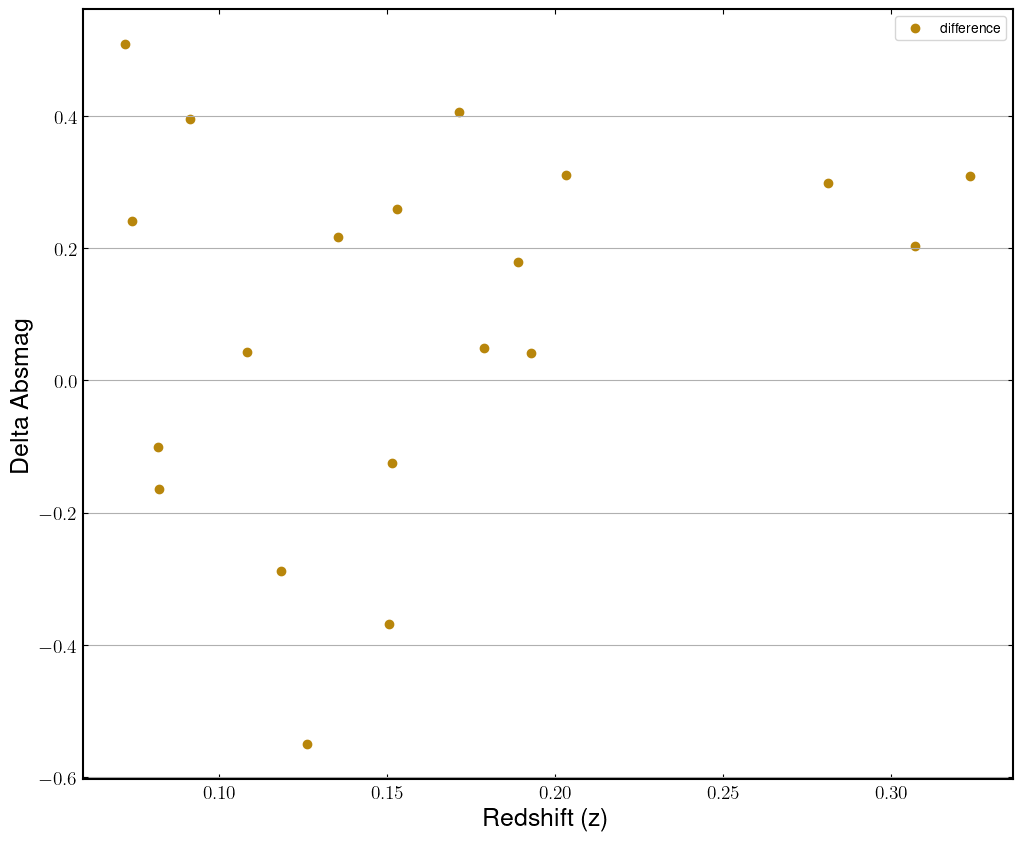

In [95]:
fig, ax = plt.subplots()
ax1 = ax.scatter(phot_reds, delta_Mr, c='darkgoldenrod', label='difference')

ax.legend()
ax.set_ylabel('Delta Absmag')
ax.set_xlabel('Redshift (z)')

ax.grid(axis='y')
fig.set_size_inches(12,10)
plt.show()

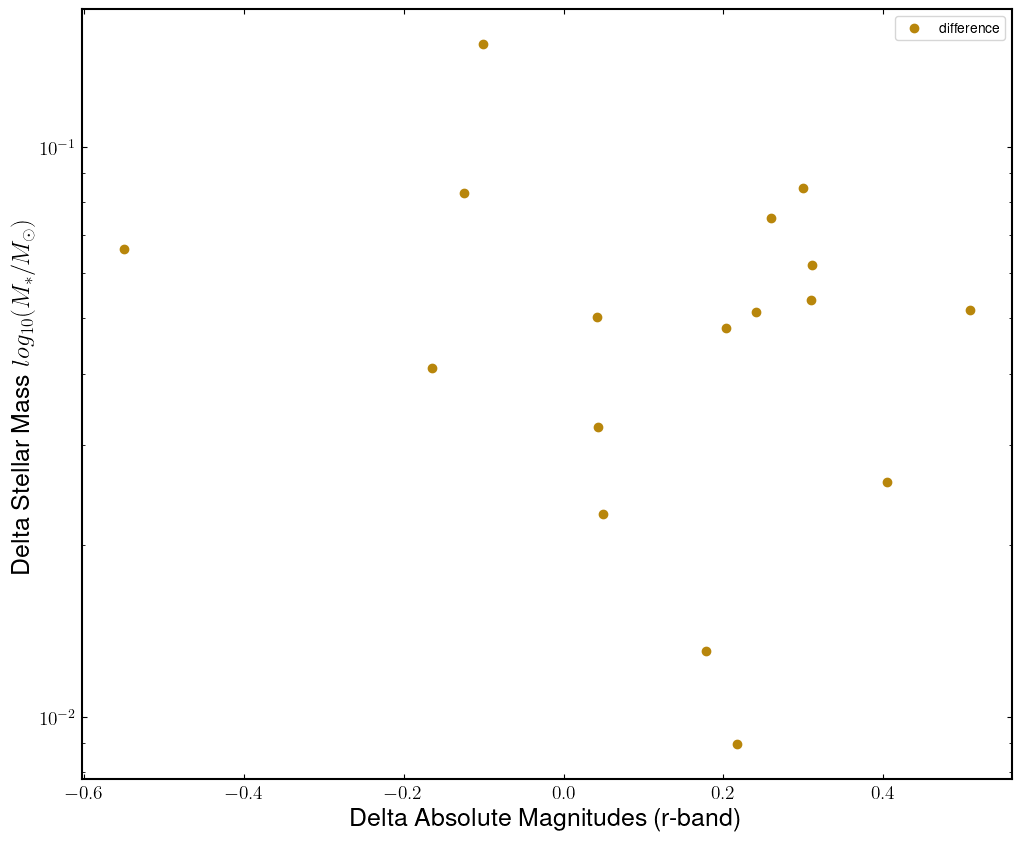

In [96]:
fig, ax = plt.subplots()
plt.scatter(delta_Mr, delta_sm, c='darkgoldenrod', label='difference')

ax.set_yscale('log')
ax.set_xscale('linear')

ax.legend()
ax.set_ylabel(r'Delta Stellar Mass $log_{10}(M_{*}/M_{\odot})$')
ax.set_xlabel('Delta Absolute Magnitudes (r-band)')

fig.set_size_inches(12,10)
plt.show()

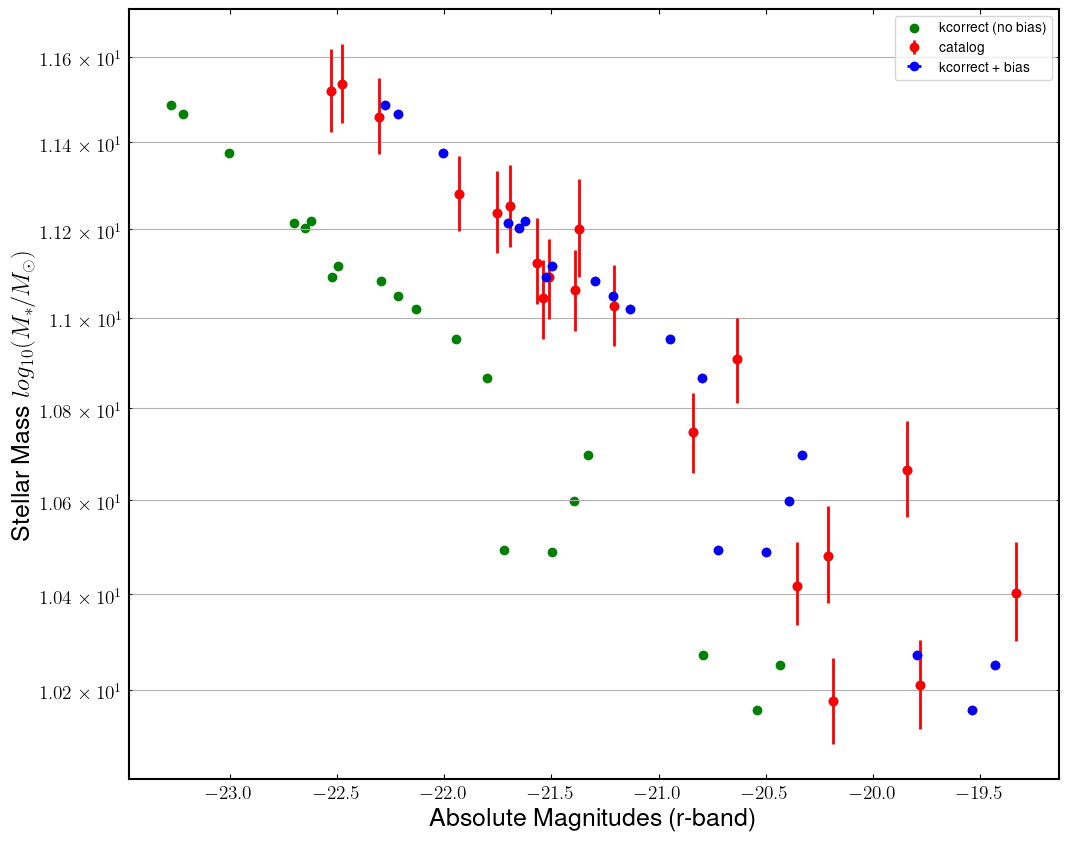

In [97]:
fig, ax = plt.subplots()
plt.scatter(absmagtest_r, sm)
plt.errorbar(absmagtest_r, sm, yerr=smtoterr,  fmt="o", c='r', label='catalog')
plt.scatter(M_r_calc, stellar_massk)
plt.errorbar(M_r_calc, stellar_massk, xerr=M_calc_err, fmt='o', c='b', label='kcorrect + bias')
plt.scatter(M_r, stellar_massk, marker='o', c='g', label='kcorrect (no bias)')

ax.set_yscale('log')
ax.set_xscale('linear')

ax.legend()
ax.set_ylabel(r'Stellar Mass $log_{10}(M_{*}/M_{\odot})$')
ax.set_xlabel('Absolute Magnitudes (r-band)')

ax.grid(axis='y',which='both')
fig.set_size_inches(12,10)
plt.show()

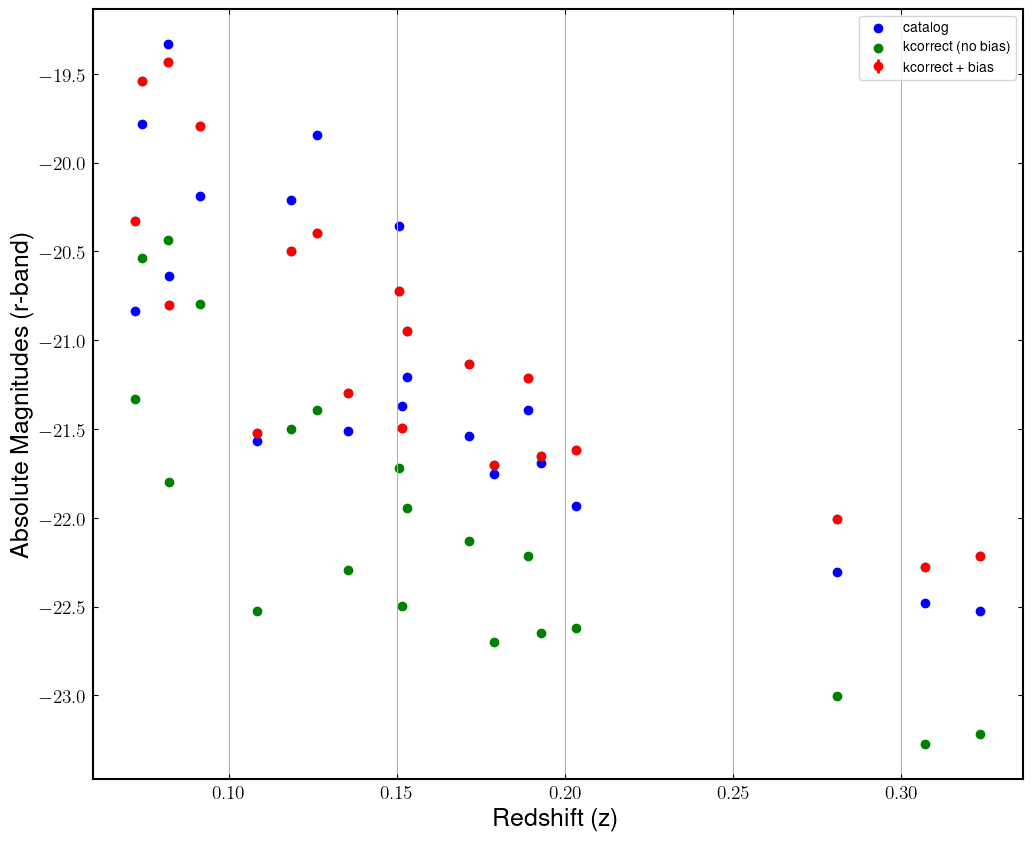

In [98]:
fig, ax = plt.subplots()

plt.scatter(phot_reds, absmagtest_r, marker="o", c='b', label='catalog')
plt.scatter(phot_reds, M_r_calc)
plt.errorbar(phot_reds, M_r_calc, yerr=M_calc_err, fmt='o', c='r', label='kcorrect + bias')
plt.scatter(phot_reds,M_r, marker='o', c='g', label='kcorrect (no bias)')

ax.set_yscale('linear')
ax.set_xscale('linear')

ax.legend()
ax.set_xlabel('Redshift (z)')
ax.set_ylabel('Absolute Magnitudes (r-band)')

ax.grid(axis='x')

fig.set_size_inches(12,10)
plt.show()

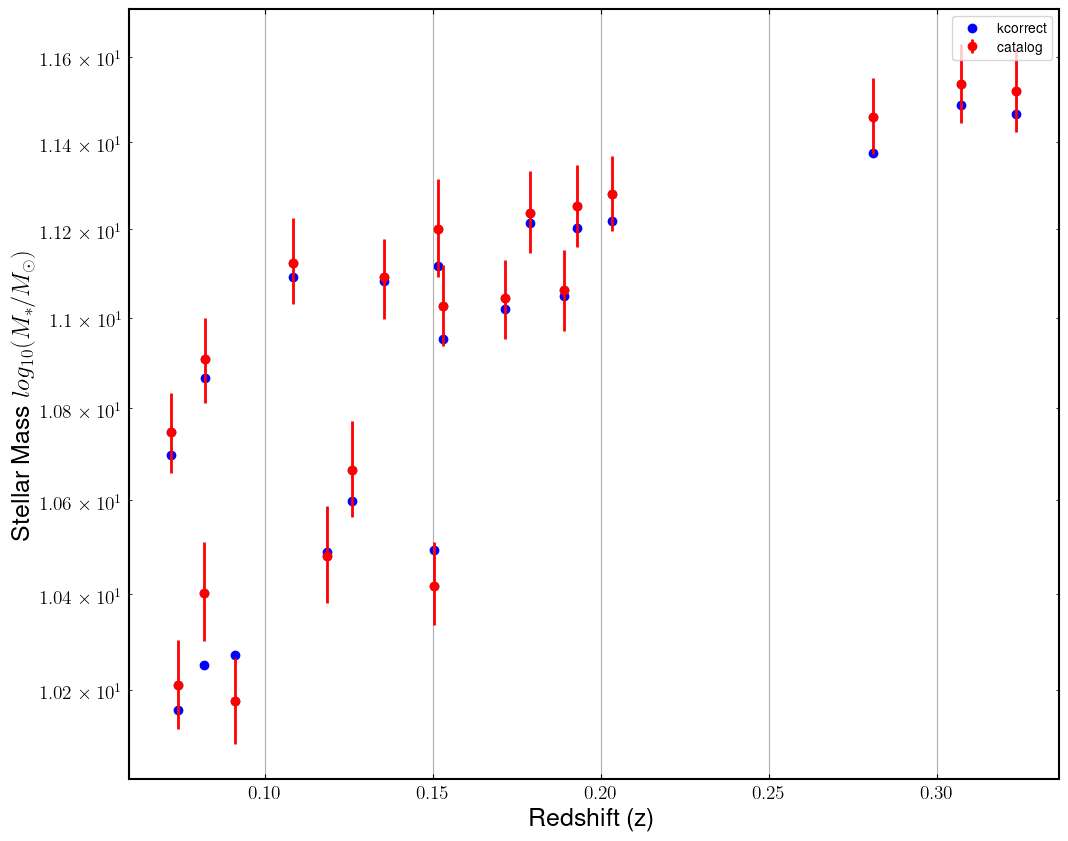

In [99]:
fig, ax = plt.subplots()
plt.scatter(phot_reds, sm)
plt.errorbar(phot_reds, sm, yerr=smtoterr, fmt="o", c='r', label='catalog')
ax1 = ax.scatter(phot_reds, stellar_massk, marker='o', c='b', label='kcorrect')

ax.set_yscale('log')
ax.set_xscale('linear')

ax.legend()
ax.set_ylabel(r'Stellar Mass $log_{10}(M_{*}/M_{\odot})$')
ax.set_xlabel('Redshift (z)')
ax.grid(axis='x')

fig.set_size_inches(12,10)
plt.show()

In [103]:
stellar_mass

array([1.59652008e+11, 3.11249093e+10, 2.91371495e+11, 1.77987267e+10,
       1.20860394e+11, 8.95938893e+10, 4.97934705e+10, 7.37254350e+10,
       1.23484615e+11, 2.36594003e+11, 1.63938856e+11, 3.96988045e+10,
       3.06488830e+11, 3.08494091e+10, 1.65636869e+11, 1.87175954e+10,
       1.04626680e+11, 1.30893506e+11, 1.12150839e+11, 1.44132822e+10])

# Bagpipes test

In [35]:
# setup for galaxy fit
def photload(ID):
    # for "" and normal calling purposes (ID conversion)
    if ID in f_kJ.index:
        pass  # it's already the right type
    elif ID.isdigit() and int(ID) in f_kJ.index:
        ID = int(ID)
    else:
        raise KeyError(f"ID '{ID}' not found in catalog")

    # photometry array
    fluxes = f_kJ.loc[ID].values
    fluxerrs = err_fJ.loc[ID].values
    photometry = np.column_stack((fluxes, fluxerrs))

    # blow up the errors associated with any missing fluxes.
    for i in range(photometry.shape[0]):
        flux, err = photometry[i]
        if (flux == 0.) or (err <= 0):
            photometry[i] = [0., 9.9e99]

        # Cap the SNR
    for i in range(photometry.shape[0]):
        flux, err = photometry[i]
        max_snr = 30. if i < 2 else 15.  # or however you want to set it
        if flux / err > max_snr:
            photometry[i, 1] = flux / max_snr

    return photometry

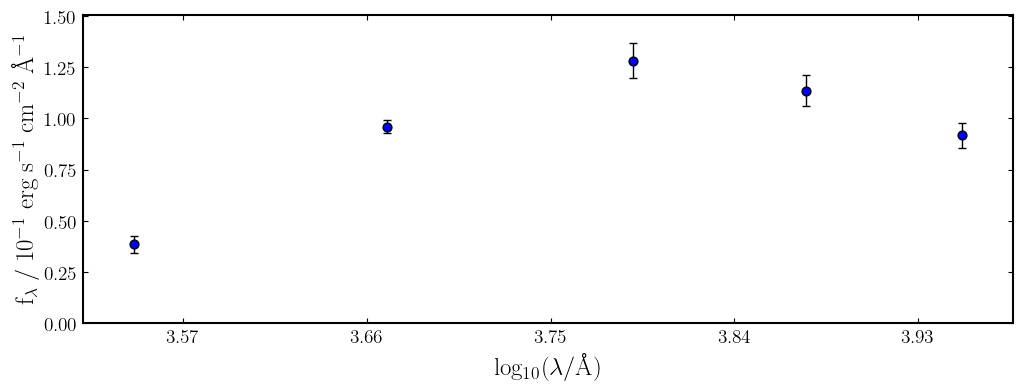


Bagpipes: fitting object 0

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    5
 *****************************************************

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the pr

/home/yavuz/miniforge3/lib/python3.10/site-packages/bagpipes/models/model_galaxy.py:559: RuntimeWarning: invalid value encountered in log10
  self.uvj = -2.5*np.log10(self._calculate_photometry(0., uvj=True))


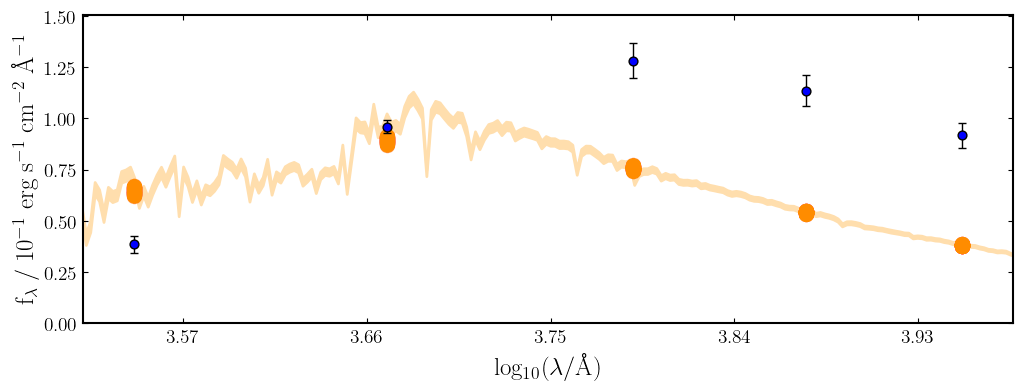

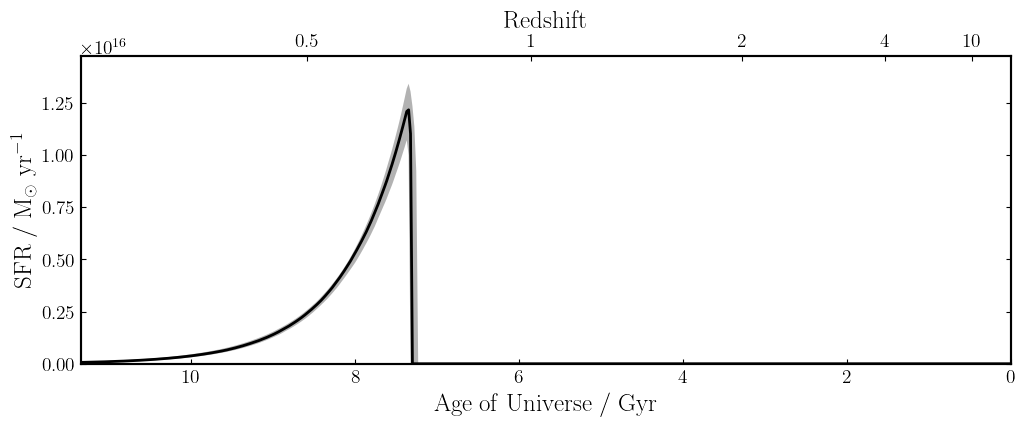

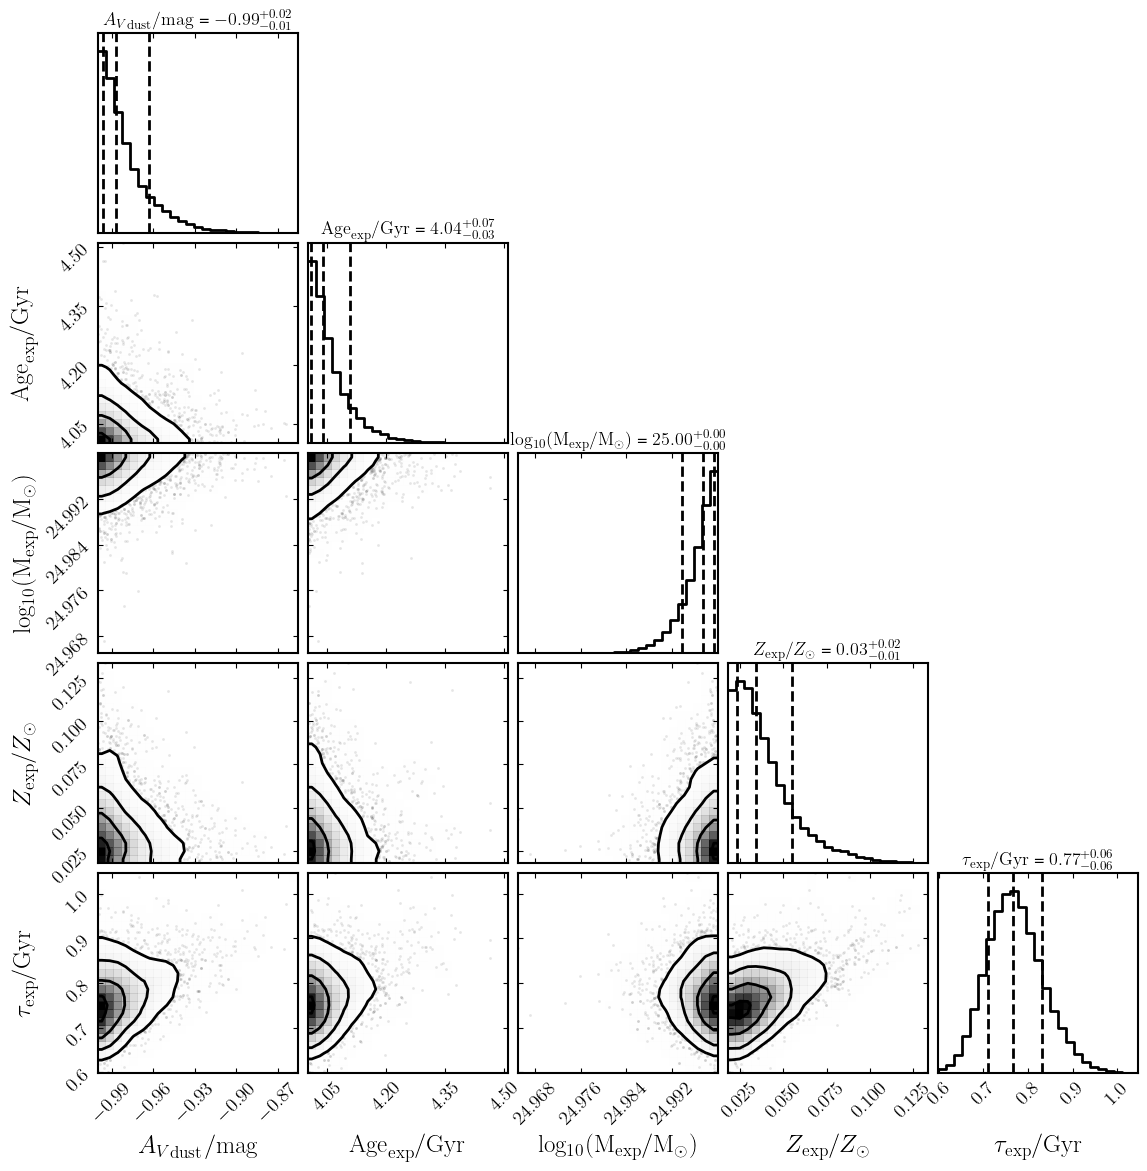

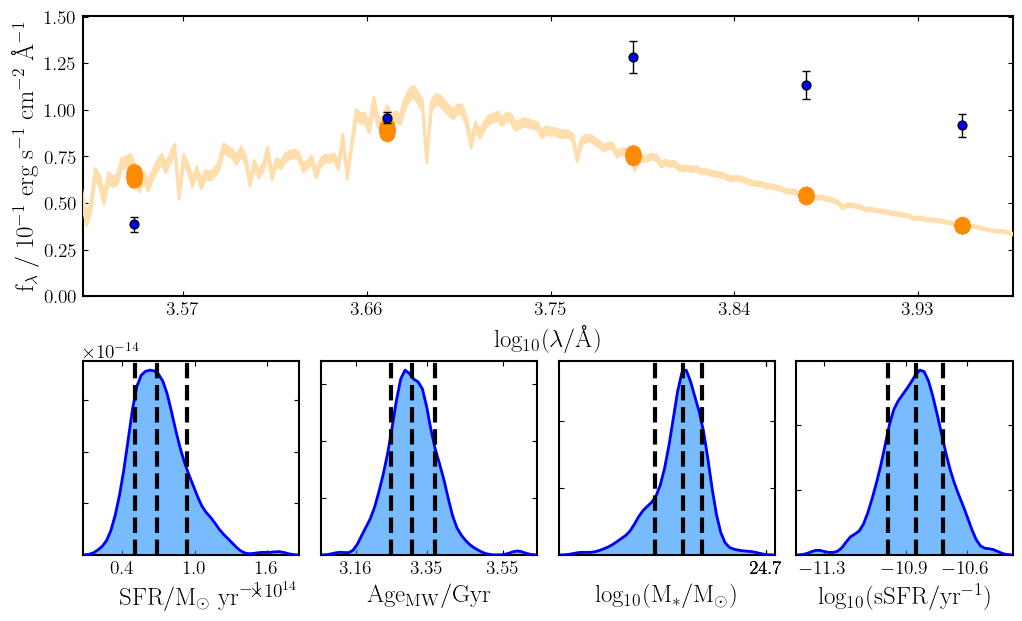

24.688348202990163


In [ ]:
filt_list = np.loadtxt("/home/yavuz/miniforge3/lib/python3.10/site-packages/bagpipes/filters/sdss_filt_list.txt", dtype="str")

for i in range (0,1):
    galaxy = pp.galaxy('0', photload, spectrum_exists=False, filt_list=filt_list)
    fig = galaxy.plot()

    #fit instructions dict.
    exp = {}                                  # Tau-model star-formation history component
    exp["age"] = (0.1, 15.)                   # Vary age between 100 Myr and 15 Gyr. In practice 
                                              # the code automatically limits this to the age of
                                              # the Universe at the observed redshift.

    exp["tau"] = (0.01, 13.)                  # Vary tau between 10 Myr and 13 Gyr
    exp["massformed"] = (5., 25.)             # vary log_10(M*/M_solar) between 1 and 15
    exp["metallicity"] = (-1., 8)              # vary Z between 0 and 5 Z_oldsolar

    dust = {}                                 # Dust component
    dust["type"] = "Calzetti"                 # Define the shape of the attenuation curve
    dust["Av"] = (0., 5.)                     # Vary Av between 0 and 5 magnitudes

    fit_instructions = {}                     # The fit instructions dictionary
    fit_instructions["redshift"] = 0.192828   # Vary observed redshift from 0 to 2
    fit_instructions["exponential"] = exp   
    fit_instructions["dust"] = dust
        
    #fitting galaxy
    fit = pp.fit(galaxy, fit_instructions)

    fit.fit(verbose=False)

    # photometry fitting & plots
    fig = fit.plot_spectrum_posterior(save=False, show=False)
    fig = fit.plot_sfh_posterior(save=False, show=False)
    fig = fit.plot_corner(save=False, show=True)

    # selective plots
    fig = plt.figure(figsize=(12, 7))
    gs = mpl.gridspec.GridSpec(7, 4, hspace=3., wspace=0.1)

    ax1 = plt.subplot(gs[:4, :])

    pp.plotting.add_observed_photometry(fit.galaxy, ax1, zorder=10)
    pp.plotting.add_photometry_posterior(fit, ax1)

    labels = ["sfr", "mass_weighted_age", "stellar_mass", "ssfr"]

    post_quantities = dict(zip(labels, [fit.posterior.samples[l] for l in labels]))

    axes = []
    for i in range(4):
        axes.append(plt.subplot(gs[4:, i]))
        pp.plotting.hist1d(post_quantities[labels[i]], axes[-1], smooth=True, label=labels[i])

    plt.show()
    '''f = open('/home/yavuz/Desktop/MT/pp_sm.txt','a')
    print(np.median(fit.posterior.samples["stellar_mass"]), file=f)
    g = open('/home/yavuz/Desktop/MT/reds_pp.txt','a')
    print(np.median(fit.posterior.samples["redshift"]), file=g)'''

    print(np.median(fit.posterior.samples["stellar_mass"]))
    '''print(np.median(fit.posterior.samples["redshift"]))'''

# Comparison for both

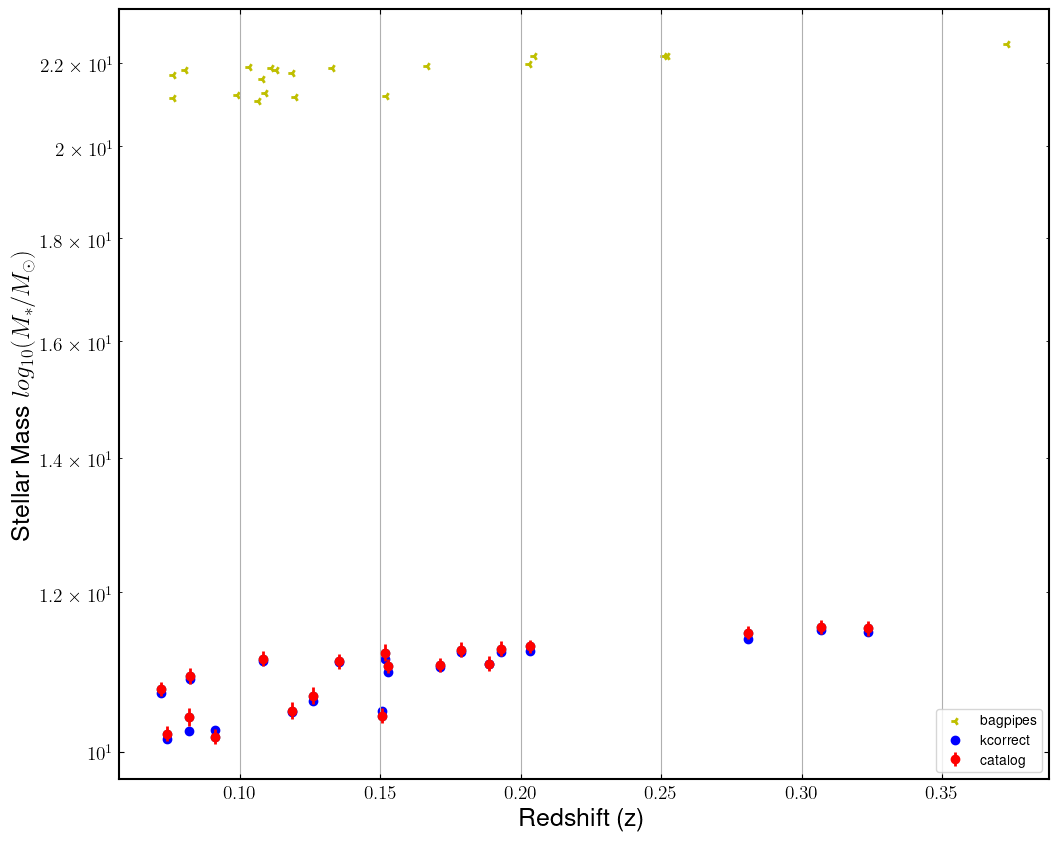

In [15]:
sm_pp = np.loadtxt('/home/yavuz/Desktop/MT/pp_sm.txt')
z_pp = np.loadtxt('/home/yavuz/Desktop/MT/reds_pp.txt')

fig, ax = plt.subplots()
ax2 = ax.scatter(z_pp, sm_pp,marker='3', c='y', label='bagpipes')
plt.scatter(phot_reds, sm)
plt.errorbar(phot_reds, sm, yerr= smtoterr, fmt='o', c='red', label='catalog')
plt.scatter(phot_reds, stellar_massk, c='b', label='kcorrect')

ax.set_xscale('linear')
ax.set_yscale('log')

ax.legend()
ax.set_ylabel(r'Stellar Mass $log_{10}(M_{*}/M_{\odot})$')
ax.set_xlabel('Redshift (z)')
ax.grid(axis='x')

fig.set_size_inches(12,10)
plt.show()